In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import anndata
import re
import scipy.sparse as scs
import concurrent.futures
import scanpy.external as sce
from concurrent.futures import ProcessPoolExecutor
import copy
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')
import math

In [2]:
def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

In [3]:
adata=sc.read_h5ad('/home/jupyter/reference_generating_new/NK/NKcells_processed_2023-11-22.h5ad')

In [4]:
np.shape(adata.obs)

(159245, 57)

In [5]:

# absolute path to search all text files inside a specific folder
path = r'*.parquet'
files = glob.glob(path)

In [6]:
df_list=[pd.read_parquet(x) for x in files]

In [7]:
df_all=pd.concat(df_list)

In [8]:
adata.obs=adata.obs.merge(df_all[['barcodes','AIFI_L1','AIFI_L2','AIFI_L3']], on="barcodes", how='left')

In [9]:
Contamination=['NK+Erythocytes Doublet',"NK+Platelet Doublet","NK+T Doublets"]
adata=adata[~adata.obs['AIFI_L2'].isin(Contamination)]

In [10]:
print(adata.obs['AIFI_L1'].nunique())
print(adata.obs['AIFI_L2'].nunique())
print(adata.obs['AIFI_L3'].nunique())

2
4
8


In [11]:
print(adata.obs['AIFI_L1'].value_counts())
print(adata.obs['AIFI_L2'].value_counts())
print(adata.obs['AIFI_L3'].value_counts())

AIFI_L1
NK cells    144063
ILC            882
Name: count, dtype: int64
AIFI_L2
NK CD56dim          130850
NK CD56bright        12209
NK Proliferating      1004
ILC                    882
Name: count, dtype: int64
AIFI_L3
NK CD56dim          103311
NK CD56bright        12209
NK intermediate      10478
NK adaptive-like      9946
NK CD56dimISG+        3834
NK CD56dimMito+       3281
NK Proliferating      1004
ILC                    882
Name: count, dtype: int64


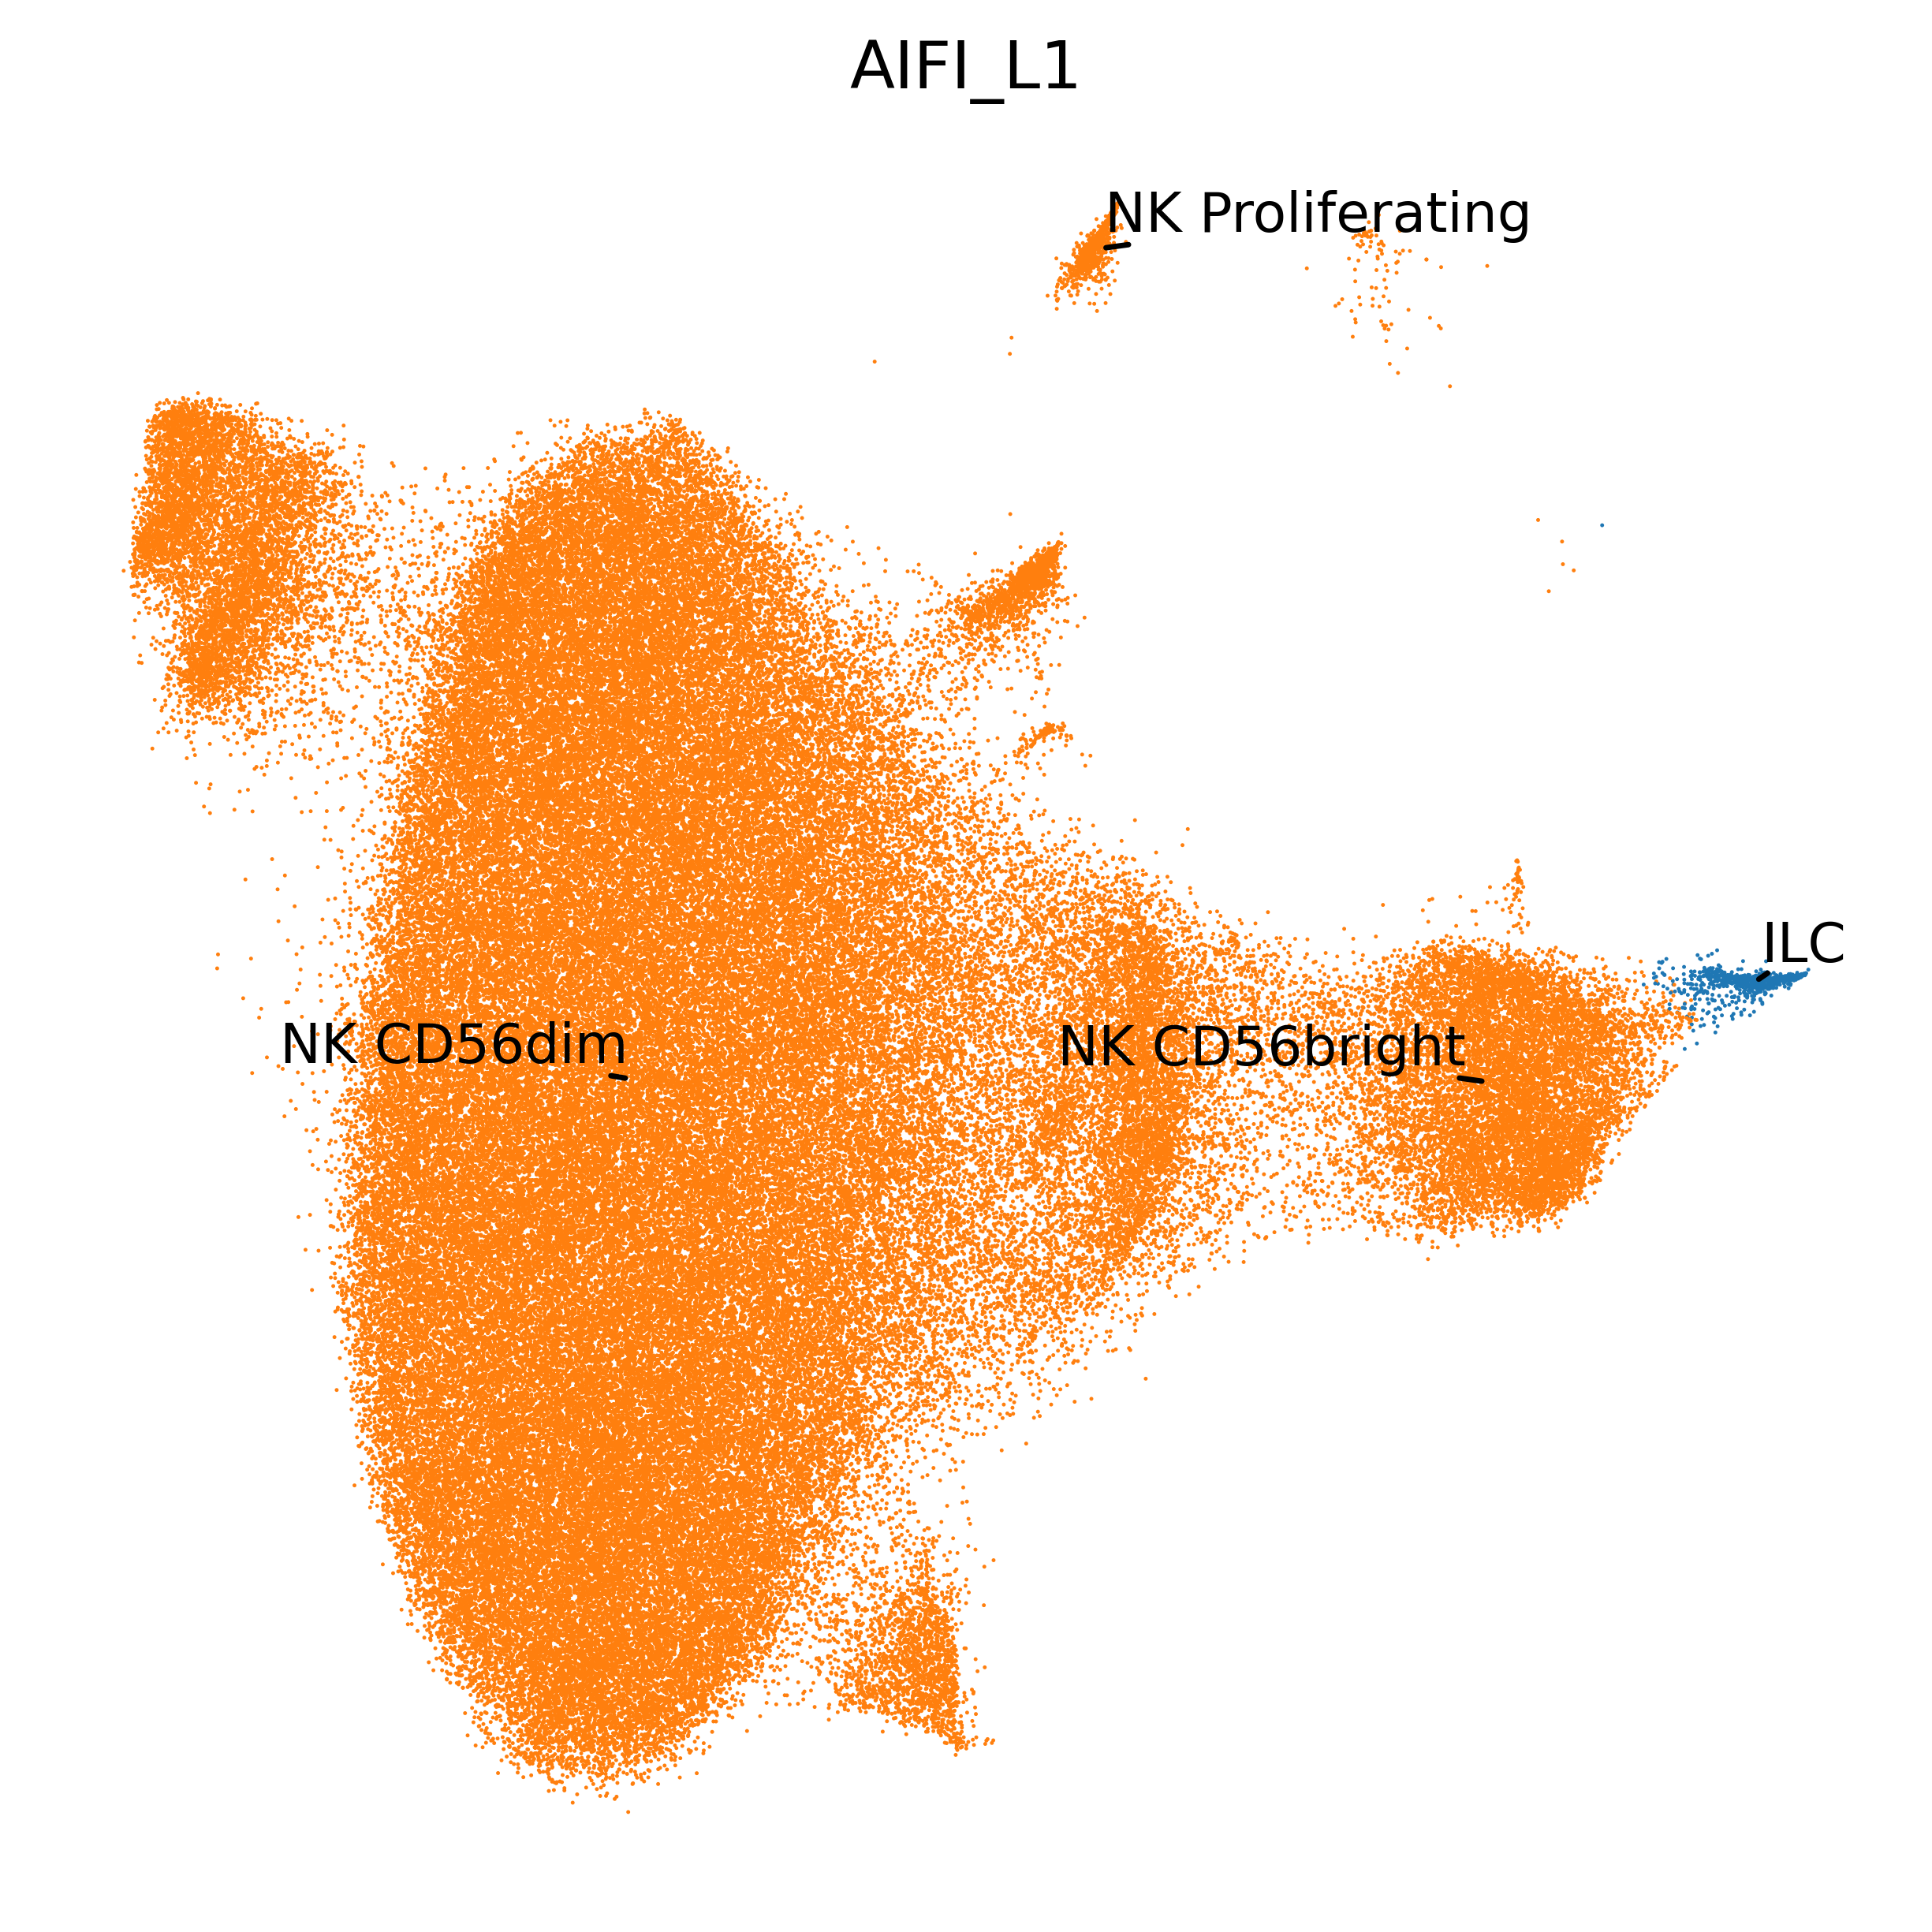

In [12]:
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": 500, "figure.frameon": False}):
    ax=sc.pl.umap(adata, color=['AIFI_L1'], size=2,show=False,legend_loc=None,ncols=1 ,frameon=False)
    gen_mpl_labels(
        adata,
        "AIFI_L2",
        exclude=(""),  
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
        text_kwargs=dict(fontsize=10),)
    fig = ax.get_figure()
    fig.tight_layout()

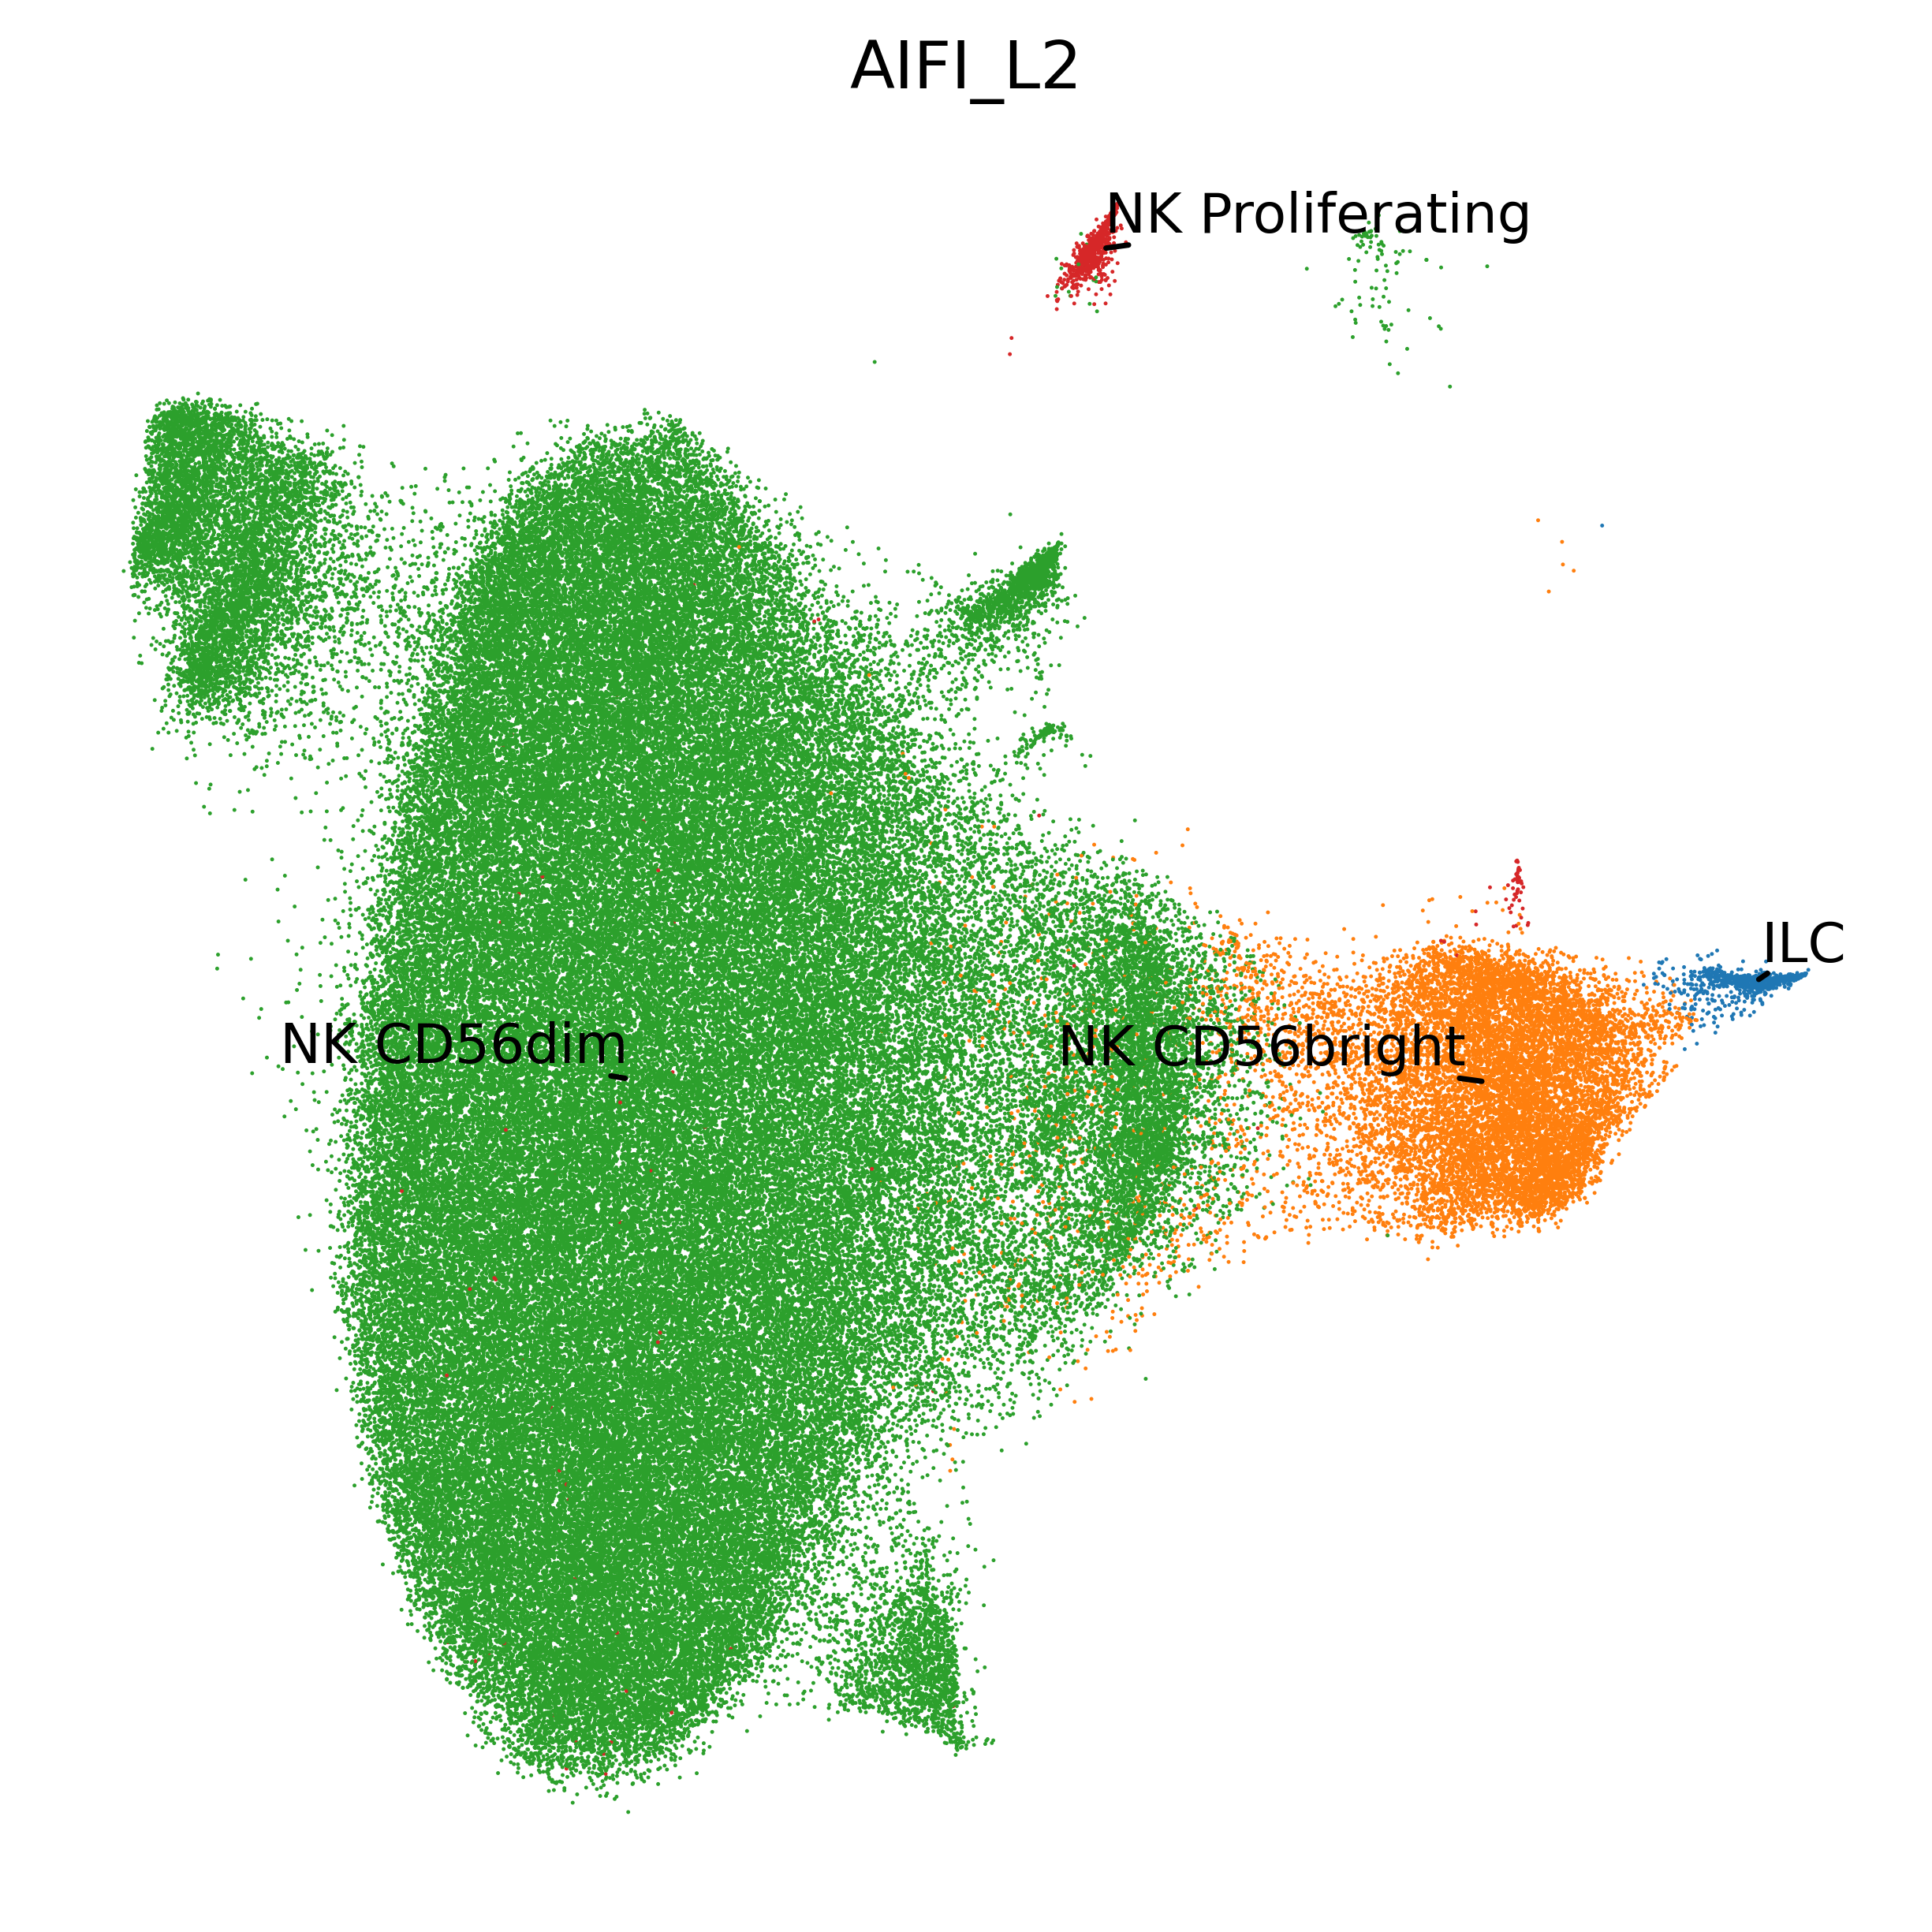

In [13]:
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": 500, "figure.frameon": False}):
    ax=sc.pl.umap(adata, color=['AIFI_L2'], size=2,show=False,legend_loc=None,ncols=1 ,frameon=False)
    gen_mpl_labels(
        adata,
        "AIFI_L2",
        exclude=(""),  
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
        text_kwargs=dict(fontsize=10),)
    fig = ax.get_figure()
    fig.tight_layout()

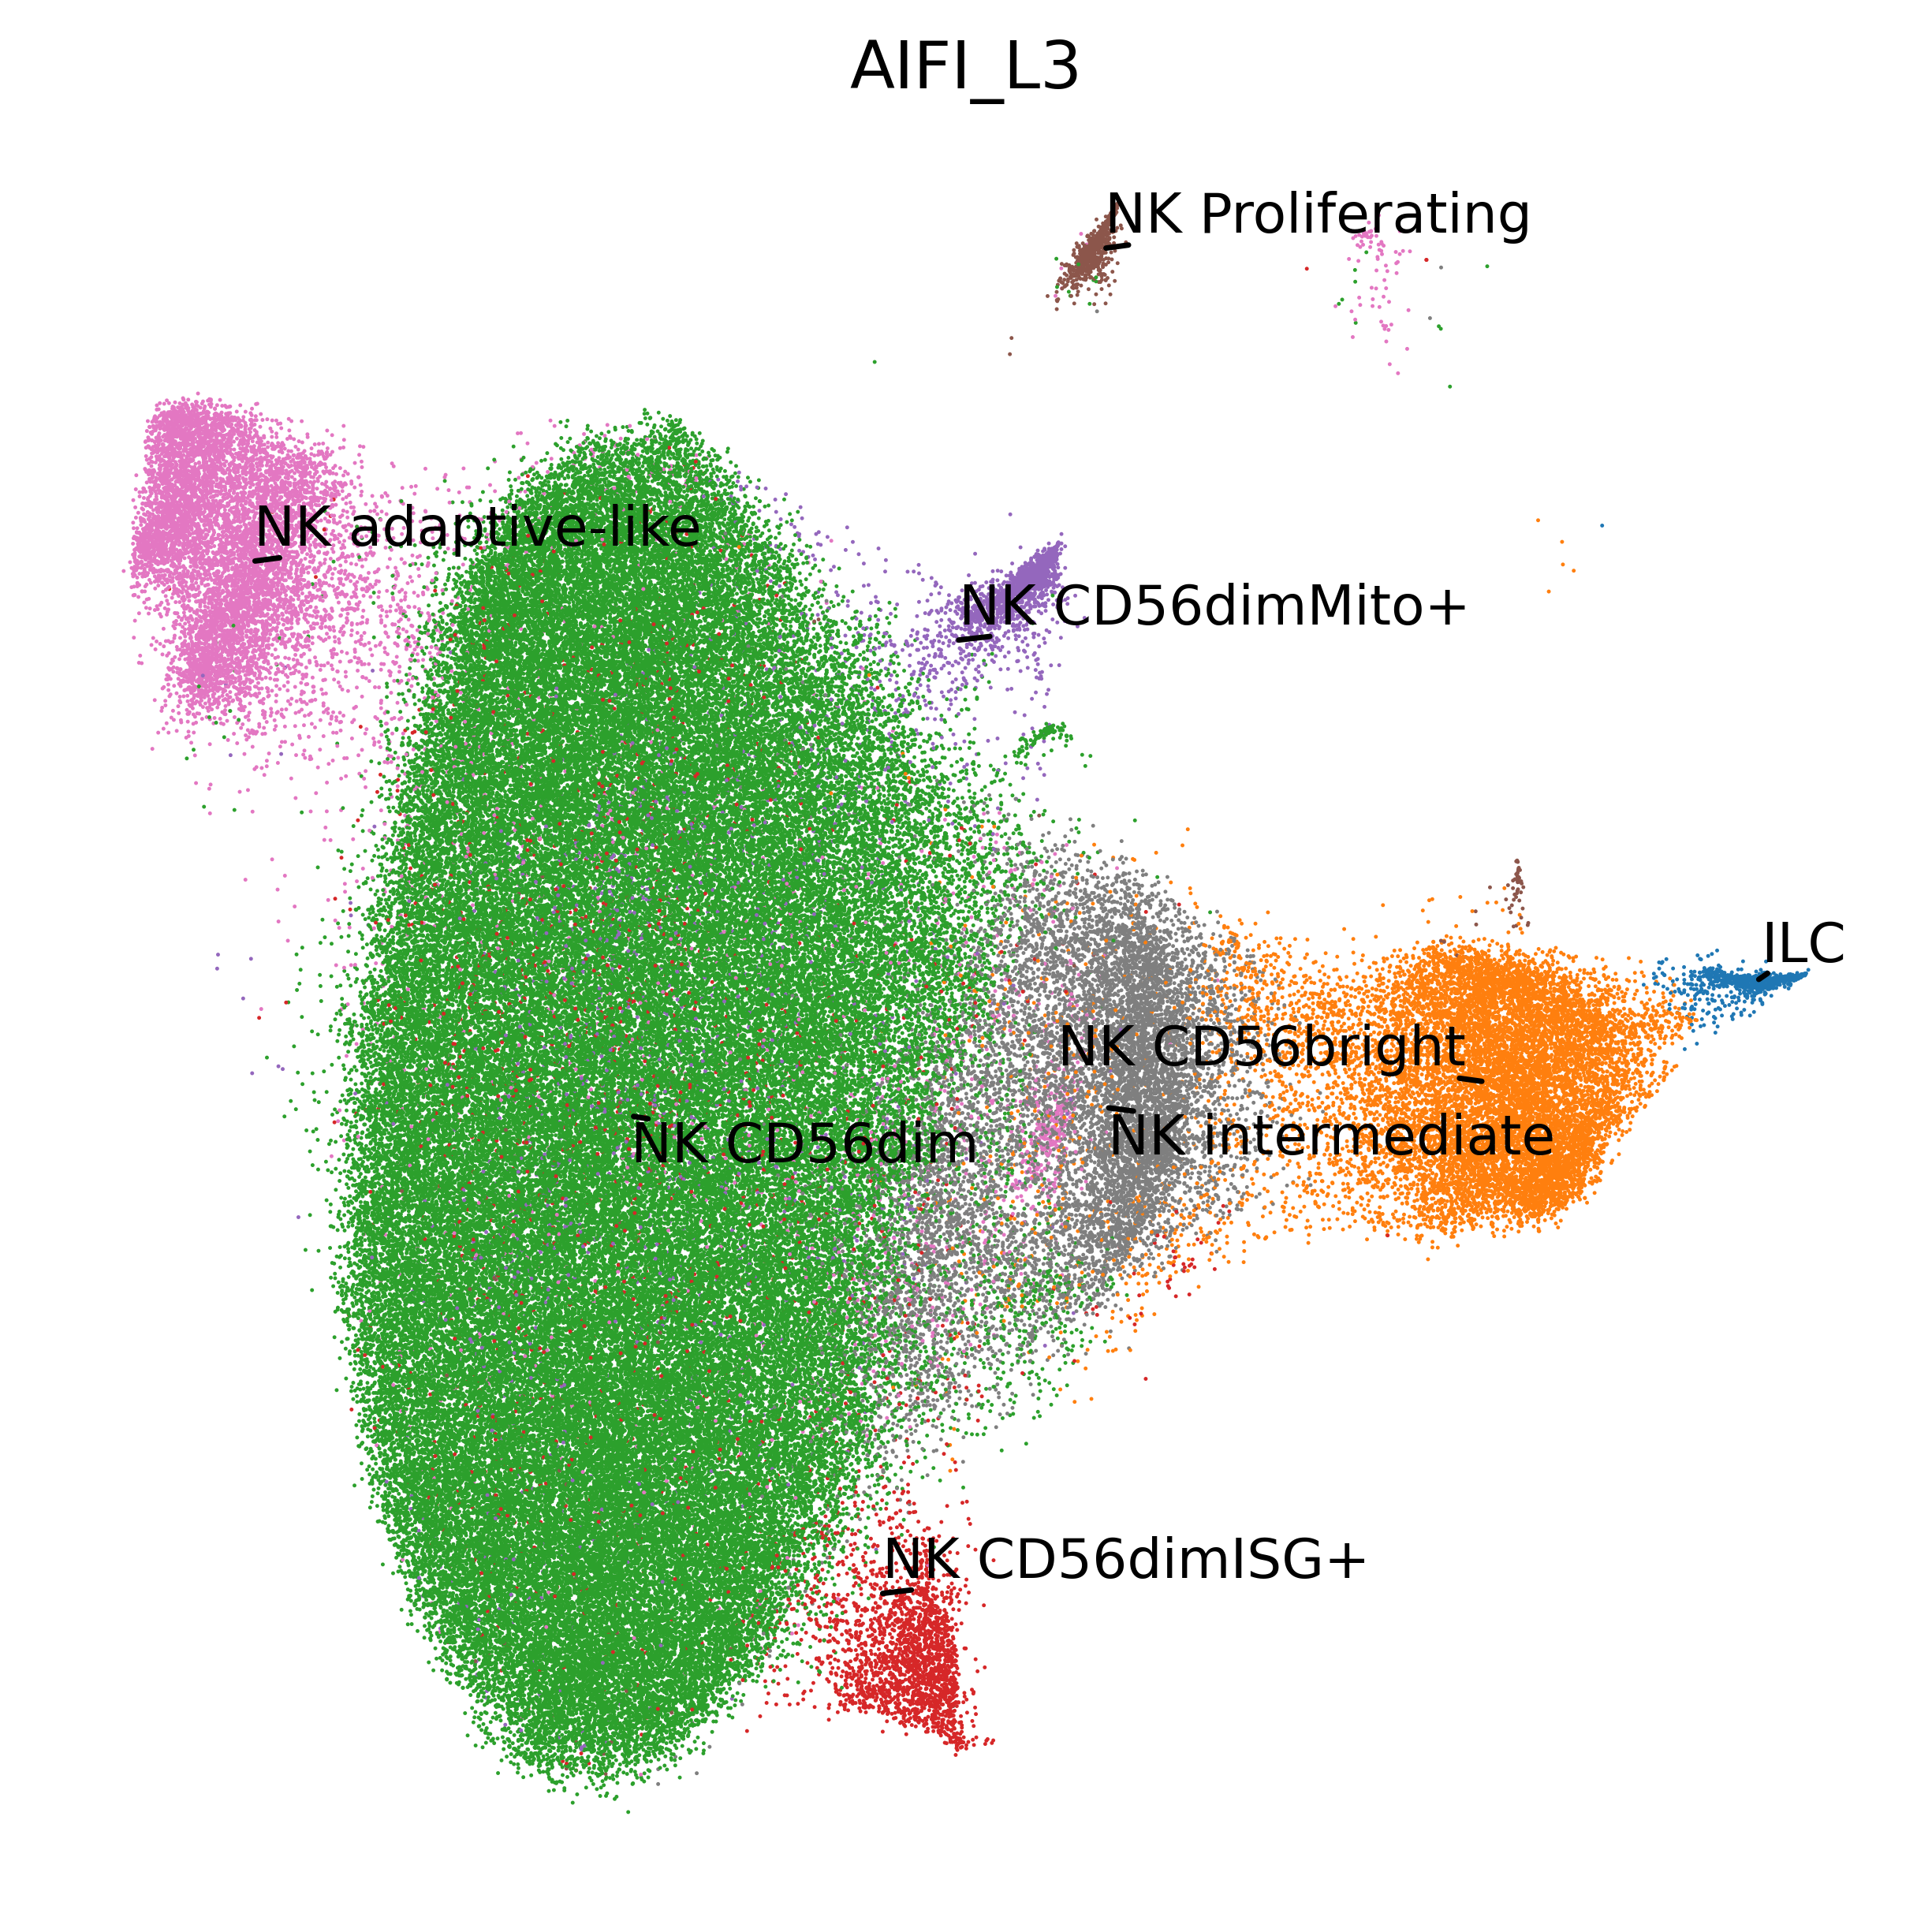

In [14]:
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": 500, "figure.frameon": False}):
    ax=sc.pl.umap(adata, color=['AIFI_L3'], size=2,show=False,legend_loc=None,ncols=1 ,frameon=False)
    gen_mpl_labels(
        adata,
        "AIFI_L3",
        exclude=(""),  
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
        text_kwargs=dict(fontsize=10),)
    fig = ax.get_figure()
    fig.tight_layout()
    #plt.savefig('UMAP.png')

In [15]:
NK_gene_of_interests="CD3E, CD4, CD8A, TRAC, TRDC, LEF1, TCF7, CCR7, SELL, ITGB1, FAS, CD27, CD28, FOXP3, RTKN2, IKZF2, ZNF683, NKG7, KLRC2, KLRF1, KLRB1, KLRD1, GZMA, GZMK, GZMB, PRF1, GNLY, IFI44L, IRF7, MKI67, TRDV1, TRDV2, TRDV3, MME, SOX4, NCAM1, FCGR3A, CD3D, KLRC2"
NK_gene_of_interests = NK_gene_of_interests.split(', ')

In [16]:
adata=adata.raw.to_adata()
adata.raw=adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

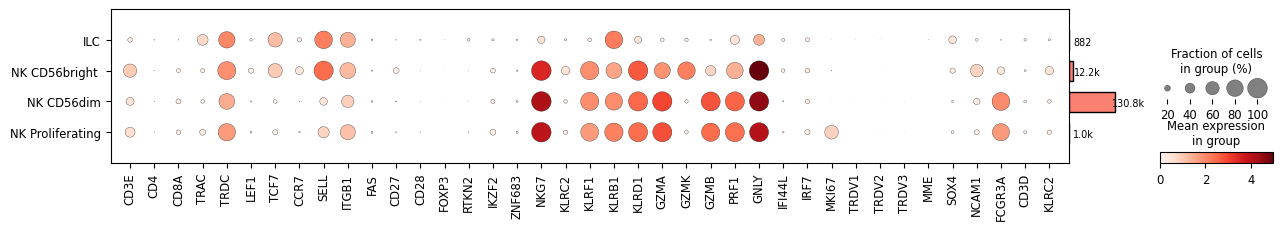

In [17]:
dp = sc.pl.dotplot(adata, NK_gene_of_interests, 'AIFI_L2', use_raw=False, dendrogram=True,figsize=(15,2),return_fig=True)
dp.add_totals().show()

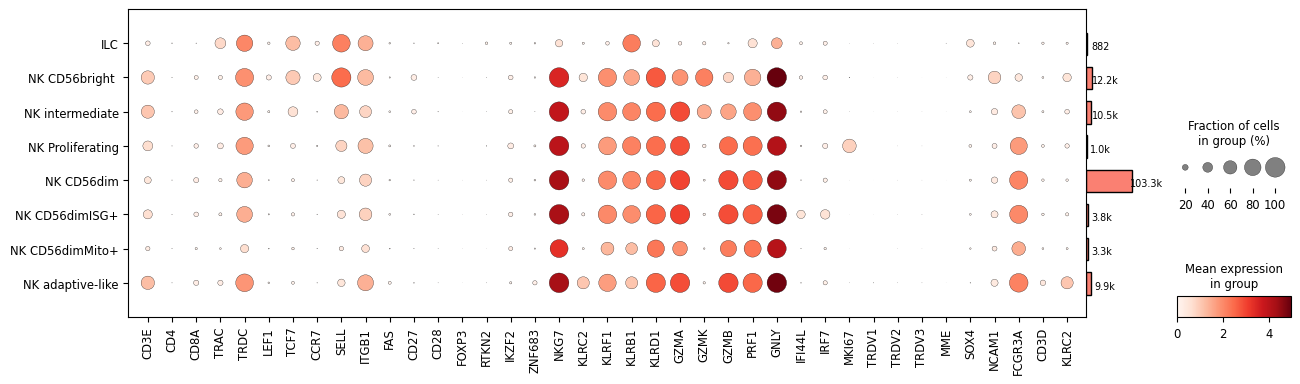

In [18]:
dp = sc.pl.dotplot(adata, NK_gene_of_interests, 'AIFI_L3', use_raw=False, dendrogram=True,figsize=(15,4),return_fig=True)
dp.add_totals().show()

In [19]:
adata.write_h5ad('NK_Labeled.h5ad')